# UAS Project Streamlit:
- **Nama:** M. Rakhmat Dramaga
- **Dataset:** Dataset yang digunakan adalah dataset gambar hitam putih. Berikut tautan sumber dataset terkait https://s3.amazonaws.com/google-landmark/train/images_001.tar
- **URL Website:** [Di isi jika web streamlit di upload]


# Menentukan Pertanyaan Bisnis

- Bagaimana penerapan teknologi warna pada gambar hitam putih dapat meningkatkan pengalaman pengguna pada aplikasi fotografi?
- Sejauh mana peningkatan kualitas gambar hitam putih dapat diukur setelah menerapkan teknologi pemberian warna?
- Apakah pemberian warna pada gambar hitam putih dapat meningkatkan daya tarik visual produk fotografi dan mendukung kebutuhan pasar saat ini?

# Import Semua Packages/Library yang Digunakan

In [2]:
from PIL import Image
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Model

from PIL import Image,ImageCms
from skimage import io, color

import numpy as np
from matplotlib import pyplot as plt

# Data Wrangling

## Gathering Data

In [1]:
! wget https://s3.amazonaws.com/google-landmark/train/images_001.tar
! tar -xf images_001.tar

--2024-02-06 14:47:56--  https://s3.amazonaws.com/google-landmark/train/images_001.tar
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.203.144, 54.231.139.184, 54.231.227.48, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.203.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1063727616 (1014M) [application/x-tar]
Saving to: ‘images_001.tar’

images_001.tar      100%[===================>]   1014M  43.6MB/s    in 24s     

2024-02-06 14:48:21 (41.5 MB/s) - ‘images_001.tar’ saved [1063727616/1063727616]



## Assesing Data

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./0/",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256),
  batch_size=8)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./0/",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=8)

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



Found 8266 files belonging to 2 classes.
Using 6613 files for training.
Found 8266 files belonging to 2 classes.
Using 1653 files for validation.


## Data Preprocessing

In [9]:
def preProc(A,y):
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    B = normalization_layer(A)
    A = tf.image.rgb_to_hsv(B)
    return A[:,:,:,-1:],A

Pro_train_ds = train_ds.map(preProc)
Pro_val_ds = val_ds.map(preProc)

Pro_train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

## Data Visualization after Validation

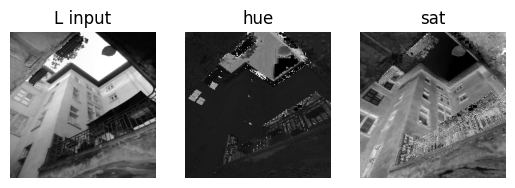

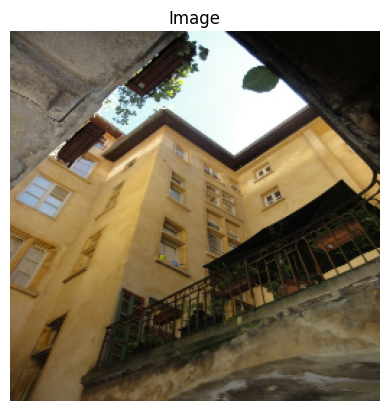

In [10]:
A = next(iter(Pro_val_ds))
fig,ax = plt.subplots(1,3,sharex=True,sharey=True)
ax[0].imshow(A[0][5][:,:,0],cmap="gray")
ax[1].imshow(A[1][5][:,:,0],cmap="gray")
ax[2].imshow(A[1][5][:,:,1],cmap="gray")
ax[0].title.set_text("L input");ax[1].title.set_text("hue");ax[2].title.set_text("sat")

ax[0].axis(False);ax[1].axis(False);ax[2].axis(False);
plt.show()

plt.imshow(tf.image.hsv_to_rgb(A[1][5]))
plt.title("Image")
plt.axis(False)
plt.show()


# Model Consctruction

## Model Production

In [11]:
tf.keras.backend.clear_session()

ALP = 0.2

inputs = tf.keras.Input(shape=(256, 256,1))

x = layers.LeakyReLU(alpha=ALP)(inputs)
for i in [16,16,16]:
    x = layers.Conv2D(i, 3,padding="same")(x)
    x = layers.LeakyReLU(alpha=ALP)(x)
    x = layers.MaxPool2D()(x)

for i in [16,16,16]:
    x = layers.Conv2D(i, 3,padding = "same")(x)
    x = layers.LeakyReLU(alpha=ALP)(x)
    x = layers.UpSampling2D(size=(2, 2))(x)

x = layers.Conv2D(2, 3,padding = "same",activation="sigmoid")(x)

outputs = layers.concatenate([x,inputs],axis=3)

model = tf.keras.Model(inputs, outputs)


## Model Compiling and Training

In [12]:
model.compile(optimizer="rmsprop", loss="MAE")

H = model.fit(Pro_train_ds,epochs=60,verbose=2,validation_data=Pro_val_ds)


Epoch 1/60
827/827 - 61s - loss: 0.1294 - val_loss: 0.1214 - 61s/epoch - 73ms/step
Epoch 2/60
827/827 - 36s - loss: 0.1231 - val_loss: 0.1195 - 36s/epoch - 44ms/step
Epoch 3/60
827/827 - 31s - loss: 0.1213 - val_loss: 0.1185 - 31s/epoch - 38ms/step
Epoch 4/60
827/827 - 37s - loss: 0.1202 - val_loss: 0.1176 - 37s/epoch - 45ms/step
Epoch 5/60
827/827 - 31s - loss: 0.1195 - val_loss: 0.1176 - 31s/epoch - 38ms/step
Epoch 6/60
827/827 - 41s - loss: 0.1190 - val_loss: 0.1171 - 41s/epoch - 50ms/step
Epoch 7/60
827/827 - 30s - loss: 0.1186 - val_loss: 0.1168 - 30s/epoch - 36ms/step
Epoch 8/60
827/827 - 34s - loss: 0.1183 - val_loss: 0.1165 - 34s/epoch - 42ms/step
Epoch 9/60
827/827 - 29s - loss: 0.1180 - val_loss: 0.1161 - 29s/epoch - 36ms/step
Epoch 10/60
827/827 - 38s - loss: 0.1178 - val_loss: 0.1160 - 38s/epoch - 46ms/step
Epoch 11/60
827/827 - 32s - loss: 0.1176 - val_loss: 0.1159 - 32s/epoch - 39ms/step
Epoch 12/60
827/827 - 38s - loss: 0.1174 - val_loss: 0.1160 - 38s/epoch - 46ms/step
E

## Model Evaluation and Visualization

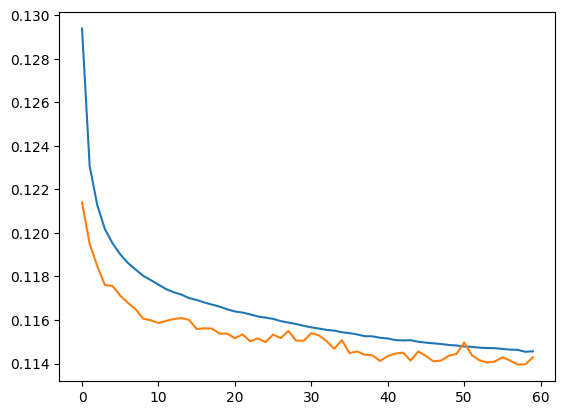

In [13]:
plt.plot(H.history["loss"])
plt.plot(H.history["val_loss"])

In [14]:
it = iter(Pro_val_ds)

## Model Saving

In [15]:
model.save("recolor.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
!zip -r /content/Recolor.zip /content/Recolor/

	zip warning: name not matched: /content/Recolor/

zip error: Nothing to do! (try: zip -r /content/Recolor.zip . -i /content/Recolor/)
